In [187]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `C:\Users\mwaugh\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...
Precompiling PerlaTonettiWaugh


┌ Info: Recompiling stale cache file C:\Users\mwaugh\.julia\compiled\v1.0\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1190


In [2]:
import Pkg; Pkg.add("Plots")
using PerlaTonettiWaugh, Plots, BenchmarkTools

 Resolving package versions...
  Updating `C:\Users\mwaugh\github\PerlaTonettiWaugh.jl\Project.toml`
 [no changes]
  Updating `C:\Users\mwaugh\github\PerlaTonettiWaugh.jl\Manifest.toml`
 [no changes]


In [3]:
gr(fmt = :png)

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

Below are the results from the matlab calibration with the corresponding letters:


In [4]:
#cal = (d = 2.7943, θ = 4.9412, κ = 0.0088, χ = 1/2.3928, υ = 0.0689, σ = 4.0520)
#cal.θ

cal = (d = 4.4007 , θ = 3.1879, κ = 0.0076, χ = 1.0/2.0927, υ = 0.1034, σ =3.0, ζ = 1.00)
cal

(d = 4.4007, θ = 3.1879, κ = 0.0076, χ = 0.47785157929946964, υ = 0.1034, σ = 3.0, ζ = 1.0)

Side note on previous version. Essentially, under this calibration, the parameters are very simmilar. Theta, chi, kappa are quite close to what we had in the prior version.

In [70]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

d_0 = parameters.d_0
d_T = cal.d
test_theta = 4.00

params_0 = merge(parameters, (d = 4.93, θ = cal.θ, κ = cal.κ, χ = cal.χ, υ = cal.υ, σ = cal.σ, ζ = cal.ζ ,)) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, θ = cal.θ, κ = cal.κ, χ = cal.χ, υ = cal.υ, σ = cal.σ, ζ = cal.ζ, )) # parameters to be used at t = T

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_algebraic(params_0) # solution at t = 0
stationary_sol = stationary_algebraic(params_T) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [71]:
stationary_sol.U_bar(1) / stationary_sol_0.U_bar(1)

1.1695104079100258

## Welfare in steady states

### Steady state at `T`

In [72]:
display_stationary_sol(stationary_sol);

g = 0.019858695866779335
z_hat = 1.664115439878888
Ω = 2.0365051699944647
y = 1.9066326701794283
c = 1.9066326701794283
U_bar = getfield(PerlaTonettiWaugh, Symbol("##46#47")){Float64,Float64,Float64,Float64}(0.019858695866779335, 0.02, 1.0, 1.9066326701794283)
λ_ii = 0.7975889227603747
L_tilde = 0.2716310478155379
z_bar = 2.6176742768362353
w = 0.872558092278745
x = 1.0
π_min = 0.05314840292091566
r = 0.09285869586677933
a = 10.948792616611767
b = 0.09160407954632357
S = 0.008979943881256034


### Steady state at `0`

In [73]:
display_stationary_sol(stationary_sol_0);

g = 0.01400350158296349
z_hat = 1.9363405999177914
Ω = 2.3887239346817255
y = 2.021059122602998
c = 2.021059122602998
U_bar = getfield(PerlaTonettiWaugh, Symbol("##46#47")){Float64,Float64,Float64,Float64}(0.01400350158296349, 0.02, 1.0, 2.021059122602998)
λ_ii = 0.8555013620214984
L_tilde = 0.26168109883366103
z_bar = 2.7373796328528033
w = 0.9124598776176011
x = 1.0
π_min = 0.04926561716852751
r = 0.0870035015829635
a = 12.559045857084305
b = 0.07204438264367723
S = -0.009685829976120499


### Outstanding Issue \#1: Sensetivity of growth to trade.

This is a big difference relative to previous version. As noted above, with parameters values that are quite simmilar to what we had before, the growth rate is changing a lot with only a very small change in trade flows. Why?

---

# Transition dynamics

Setup for optimizer:

In [152]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, z_grid), Ω_0 = Ω_0, transition_iterations = 0, T = 50.0));

Find the corresponding solution

In [153]:
@time result = solve_full_model(settings; impose_E_monotonicity_constraints = true)
solved = result.solution;
E_nodes = result.E_nodes;

solved = solved.results;

  1.273879 seconds (4.46 M allocations: 1.834 GiB, 17.44% gc time)


---
## Welfare Gains

In [138]:
print("Utility in initial SS: ", stationary_sol_0.U_bar(1),"\n")
print("Utility in new SS: ", stationary_sol.U_bar(1),"\n")

Utility in initial SS: 70.89001364289147
Utility in new SS: 82.9066087722453


In [139]:
print("Utility immidetly after change ", solved.U[1],"\n")

Utility immidetly after change 98.52447758754522


#### Summary so far...

In the old paper, what we did was take U_0_ss at some date t, then compare it to U_ss at the same date t. This is like an instentanous jump to the new ss. This is what the first cell is looking at and note that this is like a 36 percent increase in utility. Higher than what we had in the paper, but in of the same order of magnitude. 

The next cell reprots the utility just after the change. Utility here includes the future path of consumption and change in growth rate, so it "bakes in" the transition path. Here it goes up by much more than utility in the new SS. This is what I was expecting given the dynamics of consumption. 

Just a reminder about how the function `counsumption_equivalent(U_new, U_old, parameters)` works, it takes U_new and then U_old in that order, then evaluates the **gross** increase in consumption. 100 times this value **minus one** gives the permanent, percent increase in consumption required to make the agent indifferent between the two paths. 

In [188]:
T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar(0), stationary_sol_0.U_bar(0), parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

SS to SS welfare gain: 26.424702563451618


In [189]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(0), parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: 79.17593956498446


### Relative to initial notebook computations

- SS to SS, the issue here is that we should compare **at date 0** utility in the first ss vs. the second ss. This is what we must have been doing in the previous version of the paper. The previous calulation in the old notebook had 
```consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)```
which took **date T** utility and compard them. The problem is that this now depends on date T. So if we picked T to be arbitraily large, then utility will be arbitraily different.

- Following the same logic, the transition path should compare **date 0** utility with the initial value from the transition path. So what we want to do is to compare everything at 0. In the previous calculation, we had
```consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), parameters)```
were comparing the initial utility relative to ss utility on the old path at date T. So the initial blue point below versues the last orange dashed point. **See the figure below**

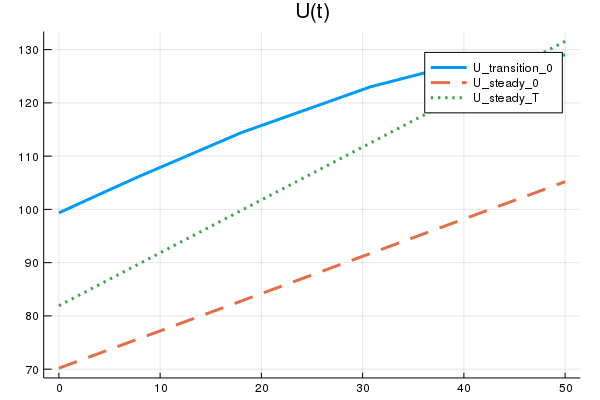

In [185]:
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

### Outstanding Issue \#2: Welfare Gains still depend on T in transition path.

The stuff above I think is correct, the one issue is why does the welfare gains, inclusive of the transition path seem to depend on T??? So change T above from 40 to 75 or 100, then the welfare gains fall alot? Why?

---
## Ploting and other checks

In [186]:
solved.U[T]

ArgumentError: ArgumentError: invalid index: 50.0 of type Float64

In [97]:
println("E_nodes (sorted) : ")
sort(E_nodes)

E_nodes (sorted) : 


14-element Array{Float64,1}:
 -0.91839  
 -0.797426 
 -0.61209  
 -0.500276 
 -0.319928 
 -0.235112 
 -0.235112 
 -0.121364 
 -0.100241 
 -0.0801344
 -0.049003 
 -0.040901 
 -0.040901 
 -0.0178076

In [98]:
@show E_nodes

E_nodes = [-0.91839, -0.797426, -0.61209, -0.500276, -0.319928, -0.235112, -0.235112, -0.121364, -0.100241, -0.0801344, -0.049003, -0.040901, -0.040901, -0.0178076]


14-element Array{Float64,1}:
 -0.91839  
 -0.797426 
 -0.61209  
 -0.500276 
 -0.319928 
 -0.235112 
 -0.235112 
 -0.121364 
 -0.100241 
 -0.0801344
 -0.049003 
 -0.040901 
 -0.040901 
 -0.0178076

## Plots for Ω and residuals

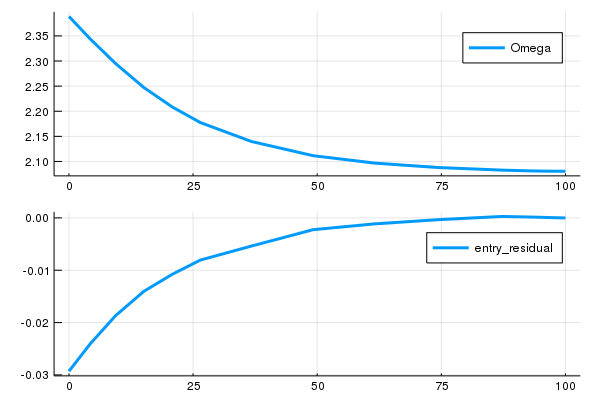

In [150]:
#solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

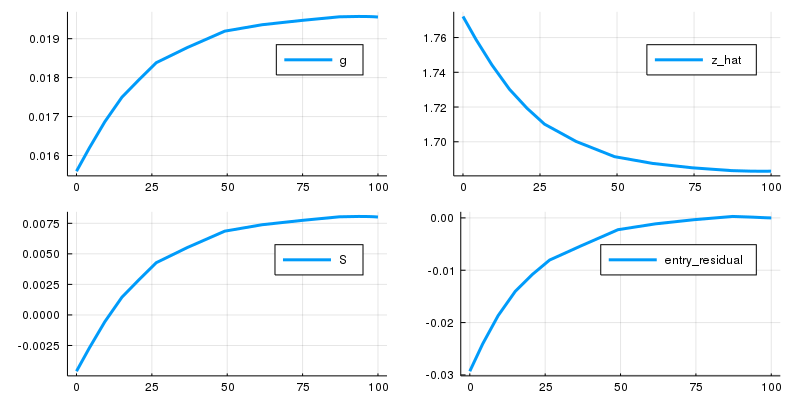

In [151]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

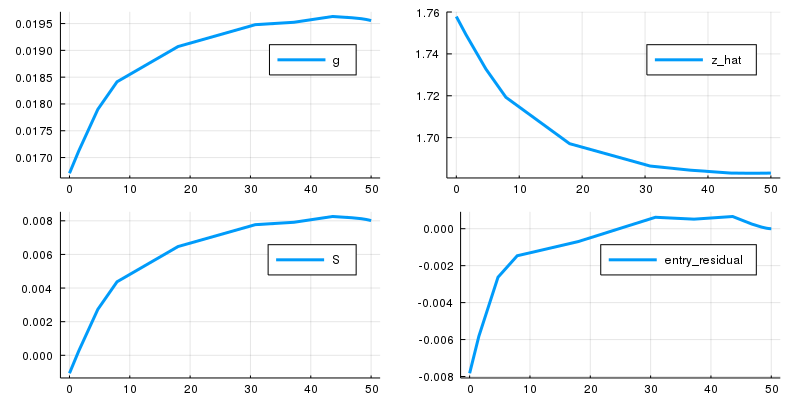

In [154]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

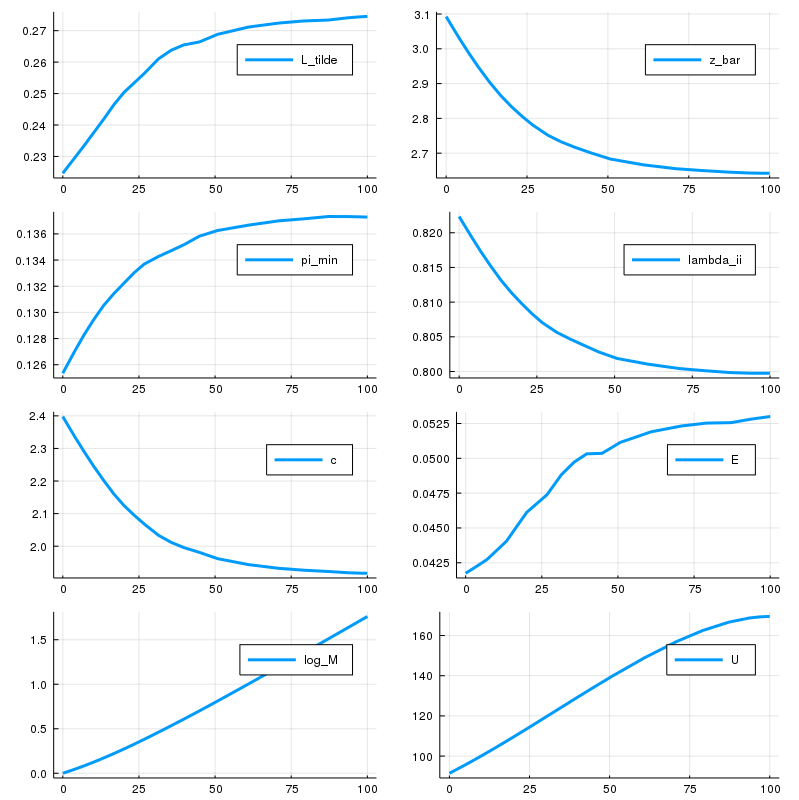

In [348]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2), size = (800, 800))

# Welfare analysis

### `log_M(t)`

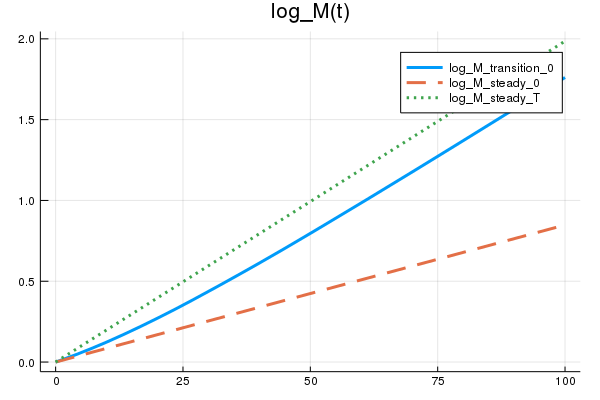

In [349]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

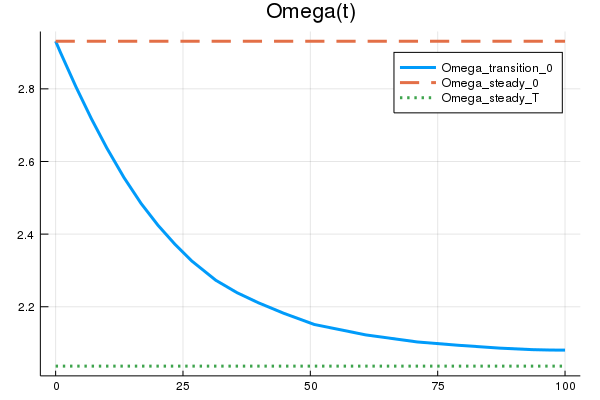

In [350]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

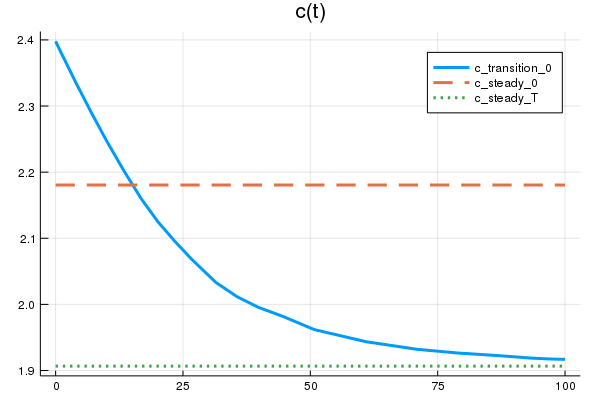

In [351]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

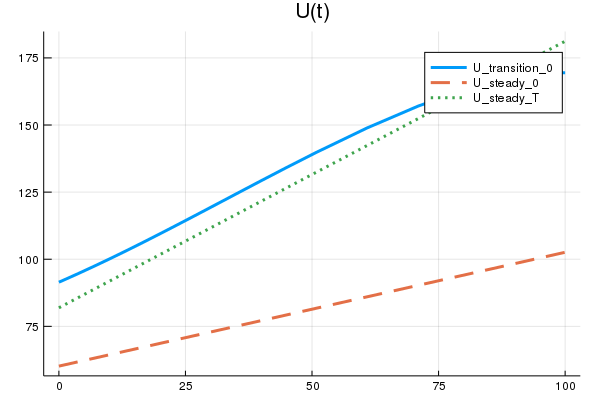

In [352]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [364]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)

1.5620502762105644

### `M(0)` by autarky and transition from `t=0`

In [354]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), parameters)

0.8002736524901947

But if we include the transition path, this falls a lot. Like down to 13 percent gain. 

### Continuation Approach

The cell below takes a while to run, but is a relatively robust way to get the solution. 

In [22]:
#= solve_continuation(3.07, # d_0 value
                        2.5019, # d_T value
                        step = 0.05, # default is 0.005 
                        params = parameter_defaults(), 
                        settings = settings_defaults(),
                        solver = solve_full_model_dfols)
=#

In [374]:
stationary_sol.U_bar(90)/stationary_sol.U_bar(89)

1.0058310218043576

In [372]:
T

100.0

In [373]:
T-1

99.0

In [375]:
T = solved.t[end]

100.0